Prashant P. Singh - 8448315

As we have seen in case of embedding, there is huge amount of effort which goes in trianing the model and coming-up with representation matrix for different context. The good point is by using the Transfer learning approach we can use these pretrained embedding and make use of those. However what if the same can be said about the models. 

'Attention is all you need': Transformers are new buzz in the feild of Deeplearning and NLP and it is said the Transformer can revolutionize the field (its already happening). The contextual embedding combined with Transformer architecture was next way forward and right now there are models which are way superior than all rpevious avatars and models. However training such models from scratch is not possible and not advisible (until really needed and you have resource too). This transfer learning approach allows us to make use of model built by big companies like ( google, facebook etc) and use 'adapt' them to our need.

For any pretrained model as has been highlighted by representation learning, the inner layer are the one which extract more basic feature and the outer layer are the ones which are building complex feature (thereby adapting to the task at hand) and are more prone to influence from the task we are doing. In this regard the best practice is to remove the last few layers, add your own Dense network and then train the model. 

Lets use the BERT (Bidirectional Encoder Representations  from Transformers, Google, 2018).[Link](https://arxiv.org/abs/1810.04805)

Important library:'[Hugging face](https://huggingface.co/docs/transformers/training )' for diffrent kind of transofrmer based models with contextual embedding. Using k-train we can use the hugging face library. 


In [1]:
# for RADAM optimizer
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [5]:
# we wil be using the ktrain for loading pretrained models and embedding for next steps as this takes care of preprcoessing automatically behind the curtain.
# https://github.com/amaiya/ktrain
! pip install ktrain

     |████████████████████████████████| 25.3 MB 1.6 MB/s 
     |████████████████████████████████| 6.8 MB 20.7 MB/s 
     |████████████████████████████████| 981 kB 50.9 MB/s 
     |████████████████████████████████| 263 kB 51.3 MB/s 
     |████████████████████████████████| 2.8 MB 39.5 MB/s 
     |████████████████████████████████| 1.2 MB 45.4 MB/s 
     |████████████████████████████████| 468 kB 48.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.4 MB/s 
     |████████████████████████████████| 61 kB 539 kB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 596 kB 52.8 MB/s 
  Created wheel for ktrain: filename=ktrain-0.28.3-py3-none-any.whl size=25292659 sha256=00cd061a6538225119e4b6670c4fef39f4d9ddcc382d6191d1fcdc9be6761d7e
  Stored in directory: /root/.cache/pip/wheels/6a/7e/c3/f46cdfc2b81c54424923b1405d7e670c35cacc11ada9a47b1c
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=b58ccda1e941e6bc

In [2]:
# some packages and library we will need
import tensorflow as tf
from tensorflow_addons.optimizers import RectifiedAdam
import tensorflow_hub as hub
import os
import shutil
import matplotlib.pyplot as plt


In [3]:
# Lets mount the Google Drive and acccess the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pickle
path = '/content/drive/MyDrive/IMDB/'  # path to the folder in google drive where data is saved
with open(path + "train.pkl", 'rb') as a, open(path + "test.pkl", 'rb') as b:
    d_train = pickle.load(a)   # loading training data
    d_test = pickle.load(b)   # loading test data 

In [6]:
import ktrain
from ktrain import text
import tensorflow as tf

In [ ]:
# creating trianing and validation set from train set

(x_train, y_train), (x_val, y_val), preproc = ktrain.text.texts_from_df(train_df=d_train,
                                                                   text_column = 'text',
                                                                   label_columns = 'label',
                                                                   val_pct = 0.7,    # training size is kept so low to make the learner plot run faster
                                                                   maxlen = 200,
                                                                   preprocess_mode = 'bert')

In [19]:
model = text.text_classifier('bert',(x_train,y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train,y_train), 
                             val_data=(x_val,y_val), 
                             batch_size= 6)

Is Multi-Label? False
maxlen is 200
done.


In [21]:
learner.lr_find()             # briefly simulate training to find good learning rate

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1024
2084/2084 [==============================] - 855s 398ms/step - loss: 3.3996 - accuracy: 0.5959


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


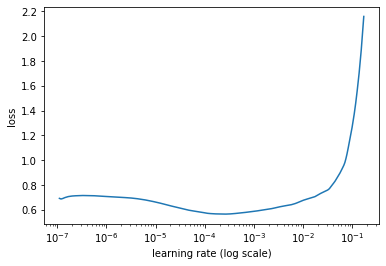

In [22]:
learner.lr_plot()

As can be seen above the good range of leanring rate is from 0.00005 to 0.0005. Therefore for this maxlen = 200 we can use the leanring rate with max value as 0.0002 and decaying down till the value of 0.00005. ( Radam is just exactly which can do this for us further it can take care of warm-up phase too.).  However we can make the change to maxlen and see what is the effect of same on learning rate ( which we will do next), for now let's try to find optimal value for number of epochs

In [11]:
model = text.text_classifier('bert',(x_train,y_train) , preproc=preproc)

# param for early stopping, number of epoch to wait before terminating the process, if no improvmenet seen for the monitored quantity
patience = 2

# loss and metrics for the models
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',   # as we are using binary accuracy which is same as accuracy for two category
                                                  patience=patience,
                                                  mode='max', restore_best_weights = False)

model.compile(optimizer=RectifiedAdam(learning_rate = 0.0001, warmup_proportion = 0.2, beta_1 = 0.9, 
                                           total_steps= 3000, weight_decay = 0.05, min_lr= 0.00002),loss= loss, metrics = metrics)


Is Multi-Label? False
maxlen is 200
done.


In [12]:
# Finding epochs value ( Number fo epochs = 4). One can argue that we can keep the epoch value where val-accuracy is highest,
# but it is advisable to go beyond that and chose epoch value when training and valid begin to diverge.

learner = ktrain.get_learner(model, 
                             train_data=(x_train,y_train), 
                             val_data=(x_val,y_val), 
                             batch_size= 16)

# https://github.com/amaiya/ktrain/blob/a871779581eea37c5e0211a3f787af8c7f2e9522/ktrain/core.py#L833
# n_cycles* cycle_len = total number of epochs, in each cycle, the optimizer lr gradually decays down.

learner.fit(lr = 1e-4,n_cycles= 3, cycle_len = 2, early_stopping= early_stopping)

Epoch 1/6
1250/1250 [==============================] - 631s 485ms/step - loss: 0.3523 - binary_accuracy: 0.8374 - val_loss: 0.2476 - val_binary_accuracy: 0.9026
Epoch 2/6
1250/1250 [==============================] - 602s 482ms/step - loss: 0.1841 - binary_accuracy: 0.9288 - val_loss: 0.2311 - val_binary_accuracy: 0.9140
Epoch 3/6
1250/1250 [==============================] - 602s 482ms/step - loss: 0.0763 - binary_accuracy: 0.9743 - val_loss: 0.2975 - val_binary_accuracy: 0.9026
Epoch 4/6
1250/1250 [==============================] - 602s 481ms/step - loss: 0.0415 - binary_accuracy: 0.9876 - val_loss: 0.3187 - val_binary_accuracy: 0.9084


In [9]:
# creating trianing and validation set from train set for maxlen = 500 (previous was 200)

(x_train, y_train), (x_val, y_val), preproc = ktrain.text.texts_from_df(train_df=d_train,
                                                                   text_column = 'text',
                                                                   label_columns = 'label',
                                                                   val_pct = 0.5,    # training size is kept so low to make the learner plot run faster
                                                                   maxlen = 200,
                                                                   preprocess_mode = 'bert')

detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [11]:
model = text.text_classifier('bert',train_data, preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=train_data, 
                             val_data=val_data, 
                             batch_size= 6)

# briefly simulate training to find good learning rate
learner.lr_find()             

Is Multi-Label? False
maxlen is 500
done.
simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1024
2084/2084 [==============================] - 2309s 1s/step - loss: 3.4755 - accuracy: 0.6152


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


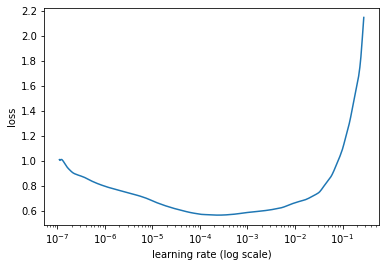

In [12]:
learner.lr_plot()

Though the graph is similar to previous but we can by looking say that the range of leanring rate is max = 0.0002 and min = 0.00008. We will use these values in Radam.

In [32]:
model = text.text_classifier('bert',(x_train,y_train) , preproc=preproc)
patience = 2
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                  patience=patience,
                                                  mode='max', restore_best_weights = False)

# model = create_model(embedding_matrix= embedding_matrix, embedding_size= embedding_size, lstm_cell_size= 128)
model.compile(optimizer=RectifiedAdam(learning_rate = 0.00008, warmup_proportion = 0.2, beta_1 = 0.9, 
                                           total_steps= 3000, weight_decay = 0.05, min_lr= 0.00002),loss= loss, metrics = metrics)


Is Multi-Label? False
maxlen is 500
done.


In [33]:
# Finding epochs value ( Number fo epochs = 4). One can argue that we can keep the epoch value where val-accuracy is highest,
# but it is advisable to go beyond that and chose epoch value when training and valid begin to diverge.

learner = ktrain.get_learner(model, 
                             train_data=(x_train,y_train), 
                             val_data=(x_val,y_val), 
                             batch_size= 6)
learner.fit(lr = 1e-4,n_cycles= 4, cycle_len = 2, callbacks= [early_stopping])

Epoch 1/8
3334/3334 [==============================] - 1856s 548ms/step - loss: 0.2883 - binary_accuracy: 0.8744 - val_loss: 0.1845 - val_binary_accuracy: 0.9268
Epoch 2/8
3334/3334 [==============================] - 1824s 547ms/step - loss: 0.1302 - binary_accuracy: 0.9553 - val_loss: 0.3328 - val_binary_accuracy: 0.9014
Epoch 3/8
3334/3334 [==============================] - 1823s 547ms/step - loss: 0.0668 - binary_accuracy: 0.9776 - val_loss: 0.2504 - val_binary_accuracy: 0.9208


We can now make final run on the data set for amxlen = 200 and maxlen = 500

In [7]:
# creating data set for maxlen = 200
(x_train, y_train), (x_val, y_val), preproc = ktrain.text.texts_from_df(train_df=d_train,
                                                                   text_column = 'text',
                                                                   label_columns = 'label',
                                                                   val_df = d_test,    # using test data now
                                                                   maxlen = 200,
                                                                   preprocess_mode = 'bert')

['not_label', 'label']
   not_label  label
0        1.0    0.0
1        1.0    0.0
2        1.0    0.0
3        0.0    1.0
4        0.0    1.0
['not_label', 'label']
   not_label  label
0        0.0    1.0
1        0.0    1.0
2        1.0    0.0
3        1.0    0.0
4        0.0    1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [9]:
model = text.text_classifier('bert',(x_train,y_train) , preproc=preproc)
patience = 2
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

model.compile(optimizer=RectifiedAdam(learning_rate = 0.0001, warmup_proportion = 0.2, beta_1 = 0.9, 
                                           total_steps= 3000, weight_decay = 0.1, min_lr= 0.00002),loss= loss, metrics = metrics)



Is Multi-Label? False
maxlen is 200
done.


In [10]:

learner = ktrain.get_learner(model, 
                             train_data=(x_train,y_train), 
                             batch_size= 16)
                              
learner.fit_onecycle(lr = 1e-4,epochs = 4)   # epoch value of 4 is determined from previous run using early stopping



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
1563/1563 [==============================] - 757s 459ms/step - loss: 0.3739 - binary_accuracy: 0.8228
Epoch 2/4
1563/1563 [==============================] - 717s 459ms/step - loss: 0.1956 - binary_accuracy: 0.9234
Epoch 3/4
1563/1563 [==============================] - 716s 458ms/step - loss: 0.0827 - binary_accuracy: 0.9735
Epoch 4/4
1563/1563 [==============================] - 717s 458ms/step - loss: 0.0484 - binary_accuracy: 0.9852


In [22]:
# preprocessing the test dataset using the transform object 'preproc'
x_test, y_test = preproc.preprocess_test(d_test.text, y = d_test.label)

preprocessing test...
language: en


In [13]:
# book keeping
import pandas as pd
report = pd.DataFrame(columns = ['model','Trail_loss','Train_accuracy', 'Test_loss','Test_accuracy']) 


In [14]:
# Evaluation on test data for maxlen = 200, lr = 0.0001

name = '200d_lr_0.0001'
print("Evaluating on valid set...{}".format(name))
(val_loss, val_accuracy) = learner.model.evaluate(x_train, y_train)
print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
print("Evaluating on test set...{}".format(name))
(test_loss, test_accuracy) = learner.model.evaluate(x_test, y_test)
print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]
print(report)

Evaluating on valid set...200d_lr_0.0001
782/782 [==============================] - 210s 262ms/step - loss: 0.0168 - binary_accuracy: 0.9971
loss=0.0168, accuracy: 99.7080%
Evaluating on test set...200d_lr_0.0001
782/782 [==============================] - 205s 262ms/step - loss: 0.2811 - binary_accuracy: 0.9121
loss=0.2811, accuracy: 91.2080%
            model  Trail_loss  Train_accuracy  Test_loss  Test_accuracy
0  200d_lr_0.0001    0.016768         0.99708   0.281085        0.91208


In [28]:
# running the model for maxlen = 500

(x_train, y_train), (x_val, y_val), preproc = ktrain.text.texts_from_df(train_df=d_train,
                                                                   text_column = 'text',
                                                                   label_columns = 'label',
                                                                   val_pct = 0.2,
                                                                   maxlen = 500,
                                                                   preprocess_mode = 'bert')

['not_label', 'label']
       not_label  label
4156         0.0    1.0
18325        1.0    0.0
18918        0.0    1.0
18063        0.0    1.0
22337        1.0    0.0
['not_label', 'label']
       not_label  label
22540        0.0    1.0
11155        0.0    1.0
239          1.0    0.0
14311        1.0    0.0
9243         1.0    0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [16]:
model = text.text_classifier('bert',(x_train,y_train) , preproc=preproc)
patience = 2
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

model.compile(optimizer=RectifiedAdam(learning_rate = 0.00008, warmup_proportion = 0.2, beta_1 = 0.9, 
                                           total_steps= 3000, weight_decay = 0.05, min_lr= 0.00002),loss= loss, metrics = metrics)


Is Multi-Label? False
maxlen is 500
done.


In [17]:
# fit for maxlen = 500
learner = ktrain.get_learner(model, 
                             train_data=(x_train,y_train), 
                             batch_size= 6)
learner.fit_onecycle(lr = 8e-5,epochs = 3)  # epoch value of 3 determined from previous run using early stopping



begin training using onecycle policy with max lr of 8e-05...
Epoch 1/3
4167/4167 [==============================] - 2192s 517ms/step - loss: 0.2933 - binary_accuracy: 0.8655
Epoch 2/3
4167/4167 [==============================] - 2150s 516ms/step - loss: 0.1415 - binary_accuracy: 0.9502
Epoch 3/3
4167/4167 [==============================] - 2150s 516ms/step - loss: 0.0757 - binary_accuracy: 0.9748


In [19]:
x_test, y_test = preproc.preprocess_test(d_test.text, y = d_test.label)
name = '500d_lr_0.00008'
print("Evaluating on valid set...{}".format(name))
(val_loss, val_accuracy) = learner.model.evaluate(x_train, y_train)
print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
print("Evaluating on test set...{}".format(name))
(test_loss, test_accuracy) = learner.model.evaluate(x_test, y_test)
print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]
print(report)

preprocessing test...
language: en


Evaluating on valid set...500d_lr_0.00008
782/782 [==============================] - 566s 724ms/step - loss: 0.0313 - binary_accuracy: 0.9928
loss=0.0313, accuracy: 99.2800%
Evaluating on test set...500d_lr_0.00008
782/782 [==============================] - 565s 723ms/step - loss: 0.1898 - binary_accuracy: 0.9318
loss=0.1898, accuracy: 93.1800%
             model  Trail_loss  Train_accuracy  Test_loss  Test_accuracy
0   200d_lr_0.0001    0.016768         0.99708   0.281085        0.91208
1  500d_lr_0.00008    0.031273         0.99280   0.189808        0.93180


In [20]:
report

,model,Trail_loss,Train_accuracy,Test_loss,Test_accuracy
0,200d_lr_0.0001,0.016768,0.99708,0.281085,0.91208
1,500d_lr_0.00008,0.031273,0.99280,0.189808,0.93180


As cen be seen both the models perform above 90% which was the mark acheived by our SVC model. the model with maxlen = 500 is substantially over the mark than SVC and that too using only 20k vocab size ( max_features), hence this can be improved upon further by fine tuning max_features, learning rate (further fine tuning) etc.

Refrences:

https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb